In [1]:
#importing necessary libraries
from api.mapbox_api_cycling import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
from pyproj import Geod

In [2]:
#reading in library branch and population demographics, both with geometry data
branchInfo = gpd.read_file('../data/clean/branches.csv')
censusTracts = pd.read_csv('../data/clean/population_demographics.csv')

In [3]:
#removing unecessary columns from branchInfo
branchInfo = branchInfo.drop(columns = ['HOURS OF OPERATION', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'PHONE', 'WEBSITE','PERMANENTLY_CLOSED'])
#removing unecessary columns from censusTracts
censusTracts = censusTracts[['geoid','geometry','qualifying name']]

In [4]:
#converting censusTracts to a geodataframe (we could not load it as one since it already had a geometry column so we are simply
#converting the geometry column to a proper gpd geometry column).
censusTracts = gpd.GeoDataFrame(
    censusTracts.loc[:, [c for c in censusTracts.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(censusTracts["geometry"]),
    crs="epsg:4326",
    )

In [5]:
branchInfo[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchInfo['LOCATION']]
branchInfo.loc[:, 'LATITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LATITUDE'])
branchInfo.loc[:, 'LONGITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LONGITUDE'])


In [6]:
#helper method to ensure that two polygons overlap before getting the intersection. Gets the intersection then calculates
#the percent of overlapping area for a census tract and saves it to a dictionary with the census tract geo-id as the key and
#the percent as the value.
def check(polygon1, df, geoname, dictionary,key):
   
    for i in range(len(df)):
        if polygon1.intersects(df.loc[i,geoname]): 
            overlapPolygon = (polygon1.intersection(df.loc[i,geoname]))
            poly_area, poly_perimeter = geod.geometry_area_perimeter(overlapPolygon)
            overlapArea = poly_area*-1
            propOverlap = overlapArea / df.loc[i,'Area']
            #print(propOverlap)
            dictionary[df.loc[i, key]] = propOverlap
    return dictionary
   

In [7]:
#sets the crs of gpd types
def geoSetup(gdf):
    
    gdf = gdf.set_crs('EPSG:4326')
    

In [8]:
#cdf = gdf of geometry area which you want to get the coverage score
#idf = gdf of points for which you want to get an isochrone and dictionary of percent of overlap in cdf areas
#scoreString = a string that is the name of the coverage score column you choose
#dictString = a string that is the name of the dictionary column you choose
#cgs = a string that is the name of the geometry column in the cdf
#igs = a string that is the name of the geometry column in the idf
#lat = a string that is the name of the latitude column in the idf
#lon = a string that is the name of the longitude column in the idf
#key = a string that is the name of the column in the cdf that you want to represent the key of the dictionary
#travelTime = an integer of the amount of time traveled you wish to calculate the isochrone

def appendADS(cdf,idf,scoreString,dictString,cgs,igs,lat,lon,key,travelTime):
    
    api = MapboxAPI()
    cdf[scoreString] = 0.0
    idf[dictString] = ''
    censusAreas = []
    global geod 
    geod = Geod(ellps='WGS84')
   
    geoSetup(cdf)
    geoSetup(idf)
   
    for index, row in cdf.iterrows():
        poly_area, poly_perimeter = geod.geometry_area_perimeter(row[cgs])
        poly_area = poly_area*-1
        censusAreas.append(poly_area)
    
    cdf['Area'] = censusAreas



    for i in range(len(idf)):
        dictionary = {}
        api_response =  api.get_data((idf.loc[i,lat],idf.loc[i,lon]), travelTime)
        idf.loc[i,igs] = shape(api_response)
        dictionary = check(idf.loc[i,igs],cdf,cgs, dictionary,key)
        branchInfo.loc[i,dictString]= [dictionary]
    
        for i in range(len(cdf)):
   
            if dictionary.get(cdf.loc[i, key]) != None:
                score = cdf.loc[i, scoreString]
                cdf.loc[i, scoreString] = score + dictionary.get(cdf.loc[i, key])
  
          

In [9]:
appendADS(censusTracts,branchInfo, 'score', 'list of dict','geometry','geometry','LATITUDE','LONGITUDE','geoid',5)

api = MapboxAPI()
censusTracts['score'] = 0.0
branchInfo['dictionary'] = ''
censusAreas = []
#geod = Geod(ellps='WGS84')
censusTracts = censusTracts.set_crs('EPSG:4326')
branchInfo = branchInfo.set_crs('EPSG:4326')
branchInfo[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchInfo['LOCATION']]
branchInfo.loc[:, 'LATITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LATITUDE'])
branchInfo.loc[:, 'LONGITUDE'] = pd.to_numeric(branchInfo.loc[:, 'LONGITUDE'])


for index, row in censusTracts.iterrows():
    poly_area, poly_perimeter = geod.geometry_area_perimeter(row['geometry'])
    poly_area = poly_area*-1
    censusAreas.append(poly_area)
censusTracts['calculated area'] = censusAreas



for i in range(len(branchInfo)):
    dictionary = {}
    api_response =  api.get_data((branchInfo.loc[i,'LATITUDE'],branchInfo.loc[i,'LONGITUDE']), 5)
    branchInfo.loc[i,'geometry'] = shape(api_response)
    dictionary = check(branchInfo.loc[i,'geometry'],censusTracts,'geometry', dictionary)
    branchInfo.loc[i,'dictionary']= [dictionary]
    
    for i in range(len(censusTracts)):
   
        if dictionary.get(censusTracts.loc[i, 'geoid']) != None:
            score = censusTracts.loc[i, 'score']
            censusTracts.loc[i, 'score'] = score + dictionary.get(censusTracts.loc[i, 'geoid'])
  
          

In [10]:
branchInfo

,BRANCH,LOCATION,geometry,LATITUDE,LONGITUDE,list of dict
0,Albany Park,"(41.97557881655979, -87.71361314512697)","POLYGON ((-87.71361 41.98848, -87.71486 41.987...",41.975579,-87.713613,"[{17031140800: 0.017869777983590063, 170311407..."
1,Altgeld,"(41.65719847558056, -87.59883829075173)","POLYGON ((-87.59984 41.66627, -87.60077 41.666...",41.657198,-87.598838,"[{17031540101: 0.23242767470315703, 1703155020..."
2,Archer Heights,"(41.80110836194246, -87.72648385568911)","POLYGON ((-87.72748 41.81333, -87.72848 41.812...",41.801108,-87.726484,"[{17031835200: 0.11757242024309991, 1703156040..."
3,Austin,"(41.88917312206642, -87.7658203582574)","POLYGON ((-87.76682 41.90039, -87.76982 41.898...",41.889173,-87.765820,"[{17031252101: 0.06057549649451242, 1703125210..."
4,Austin-Irving,"(41.95312267684315, -87.77928489355646)","POLYGON ((-87.77828 41.96421, -87.77929 41.963...",41.953123,-87.779285,"[{17031151200: 0.05403838781207353, 1703115060..."
...,...,...,...,...,...,...
77,West Pullman,"(41.67790647382097, -87.6431683153105)","POLYGON ((-87.64217 41.69004, -87.64325 41.688...",41.677906,-87.643168,"[{17031821402: 0.06066245818886034, 1703175060..."
78,West Town,"(41.89594730478282, -87.66829305460979)","POLYGON ((-87.66729 41.90787, -87.66829 41.906...",41.895947,-87.668293,"[{17031833000: 0.07931039815292865, 1703128040..."
79,"Whitney M. Young, Jr.","(41.7510184591363, -87.61495065361933)","POLYGON ((-87.61495 41.76441, -87.61595 41.763...",41.751018,-87.614951,"[{17031440202: 0.32475776967474607, 1703184240..."
80,Woodson Regional Library,"(41.720694885749005, -87.64304817213312)","POLYGON ((-87.64305 41.73351, -87.64422 41.732...",41.720695,-87.643048,"[{17031730600: 0.08064251498635563, 1703173050..."


In [11]:
censusTracts.sort_values(by = 'score', ascending = False)

,geoid,qualifying name,geometry,score,Area
375,17031283200,"Census Tract 2832, Cook County, Illinois","POLYGON ((-87.66120 41.87212, -87.66103 41.872...",2.222694,236545.662330
373,17031283800,"Census Tract 2838, Cook County, Illinois","POLYGON ((-87.65542 41.86702, -87.65524 41.866...",2.170788,376238.367992
376,17031833300,"Census Tract 8333, Cook County, Illinois","POLYGON ((-87.65697 41.87534, -87.65697 41.875...",2.146645,477334.036484
374,17031283100,"Census Tract 2831, Cook County, Illinois","POLYGON ((-87.66652 41.87163, -87.66644 41.871...",2.023604,216514.807951
325,17031839600,"Census Tract 8396, Cook County, Illinois","POLYGON ((-87.62152 41.83106, -87.62115 41.831...",1.994071,327052.259380
...,...,...,...,...,...
386,17031837000,"Census Tract 8370, Cook County, Illinois","POLYGON ((-87.70076 41.88285, -87.69928 41.882...",0.000000,412544.925305
425,17031841200,"Census Tract 8412, Cook County, Illinois","POLYGON ((-87.68807 41.85934, -87.68790 41.859...",0.000000,625405.827747
438,17031813801,"Census Tract 8138.01, Cook County, Illinois","POLYGON ((-87.73977 41.85865, -87.73974 41.857...",0.000000,7528.580770
439,17031813500,"Census Tract 8135, Cook County, Illinois","MULTIPOLYGON (((-87.77389 41.86546, -87.77314 ...",0.000000,3.166734


Text(0.5, 1.0, 'Percent of Coverage')

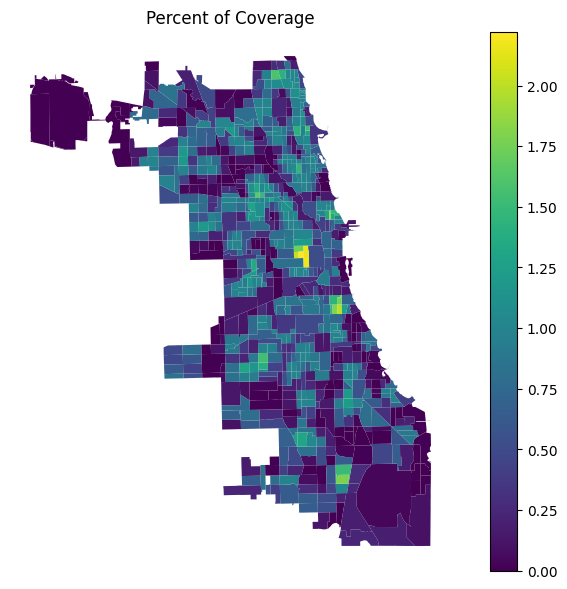

In [12]:
ax = censusTracts.plot(column = 'score', legend = True, 
                figsize=(10,7),missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "label": "Missing values",
    })


ax.set_axis_off()
ax.set_title("Percent of Coverage")

In [13]:
censusTracts['score'].mean()

0.5442904252910497